In [1]:
import Random
Random.seed!(0)
pwd()

"/home/bach/iskra"

In [2]:
include("problem/units_and_constants.jl")
include("problem/configuration.jl")
config = Config();

In [3]:
nx = 20         # number of nodes in x direction
ny = 20         # number of nodes in y direction
ts = 200        # number of time steps
Δh = 5cm        # cell size
Δt = 1ns        # time step
Lx = nx*Δh      # domain length in x direction
Ly = ny*Δh      # domain length in y direction
nothing

In [4]:
xs, ys = 0m:Δh:Lx, 0m:Δh:Ly
sx, sv = [0 Lx; 0 Ly], [0 0; 0 0]
O  = create_kinetic_species("O",  20_000, 0qe, 8mp, 1);
e  = create_kinetic_species("e-", 20_000,-1qe, 1me, 1);
iO = create_kinetic_species("O+", 20_000,+1qe, 8mp, 1);

In [5]:
using Chemistry
import RegularGrid, FiniteDifferenceMethod, ParticleInCell
config.grid    = RegularGrid.create_uniform_grid(xs, ys)
config.cells   = RegularGrid.create_staggered_grid(config.grid)
config.solver  = FiniteDifferenceMethod.create_poisson_solver(config.grid, ε0)
config.pusher  = ParticleInCell.create_boris_pusher()
config.species = [e, O, iO]

σ = CrossSection(3e6:1e6:6e6, [0.01, 0.1, 2.0, 0.01])
collisions = dsmc(@reactions begin
    σ, e + O --> O + e
end)
config.interactions = [collisions]

1-element Array{Chemistry.DirectSimulationMonteCarlo,1}:
 Chemistry.DirectSimulationMonteCarlo(Any[Chemistry.DSMC.ElasticCollision(σ: , e-, O)], Array{Float64}(undef,0,0), Array{Array{UInt32,1}}(undef,0,0), Array{Array{UInt32,1}}(undef,0,0))

In [6]:
nx, ny = size(config.grid)
mx, my = size(config.cells)
xx, yy = config.grid.x, config.grid.y
δ = ones(nx, ny)
εr  = ones(mx, my, 1)
bcs = zeros(Int8, nx, ny, 1)
bcs[ nx,  1, 1] = 1
bcs[ nx, ny, 1] = 2
set_permittivity(εr)
create_electrode(bcs .== 1, config; σ=1e3ε0)
create_electrode(bcs .== 2, config; fixed=true)

ParticleInCell.FixedPotentialElectrode(fill(0.0), 0.0, 0.0)

In [7]:
import Diagnostics

function ParticleInCell.after_loop(i, t, dt)
  Diagnostics.new_iteration("05_dsmc", i, t, dt) do it
    Diagnostics.save_diagnostic(it, "nO")
    Diagnostics.save_diagnostic(it, "O/positionOffset/x")
    Diagnostics.save_diagnostic(it, "O/positionOffset/y")
    Diagnostics.save_diagnostic(it, "O/positionOffset/z")
    Diagnostics.save_diagnostic(it, "O/position")
    Diagnostics.save_diagnostic(it, "O/momentum")
    Diagnostics.save_diagnostic(it, "O/weighting")
    Diagnostics.save_diagnostic(it, "O/charge")
    Diagnostics.save_diagnostic(it, "O/mass")
    Diagnostics.save_diagnostic(it, "O/id")
    Diagnostics.save_diagnostic(it, "ne-")
    Diagnostics.save_diagnostic(it, "e-/positionOffset/x")
    Diagnostics.save_diagnostic(it, "e-/positionOffset/y")
    Diagnostics.save_diagnostic(it, "e-/positionOffset/z")
    Diagnostics.save_diagnostic(it, "e-/position")
    Diagnostics.save_diagnostic(it, "e-/momentum")
    Diagnostics.save_diagnostic(it, "e-/weighting")
    Diagnostics.save_diagnostic(it, "e-/charge")
    Diagnostics.save_diagnostic(it, "e-/mass")
    Diagnostics.save_diagnostic(it, "e-/id")
    Diagnostics.save_diagnostic(it, "nO+")
    Diagnostics.save_diagnostic(it, "O+/positionOffset/x")
    Diagnostics.save_diagnostic(it, "O+/positionOffset/y")
    Diagnostics.save_diagnostic(it, "O+/positionOffset/z")
    Diagnostics.save_diagnostic(it, "O+/position")
    Diagnostics.save_diagnostic(it, "O+/momentum")
    Diagnostics.save_diagnostic(it, "O+/weighting")
    Diagnostics.save_diagnostic(it, "O+/charge")
    Diagnostics.save_diagnostic(it, "O+/mass")
    Diagnostics.save_diagnostic(it, "O+/id")
    Diagnostics.save_diagnostic(it, "nuDSMC")
    Diagnostics.save_diagnostic(it, "phi")
    Diagnostics.save_diagnostic(it, "E")
  end
end

nothing

In [8]:
function thermal_speed(T, m)
  kB = 1.3806503e-23
  sqrt(2kB*T/m)
end

νth = thermal_speed(300, O.m)
ParticleInCell.init(ParticleInCell.MaxwellianSource(5e3/Δt, [0 Lx; 0 Ly], [.5e6 -1e6; .5e6 -1e6]), e, Δt)
ParticleInCell.init(ParticleInCell.MaxwellianSource(5e3/Δt, [0 Lx; 0 Ly], [0.     νth; 0.   νth]), O, Δt)
@time ParticleInCell.solve(config, Δt, ts)

New diagnostics registered: nuDSMC
New diagnostics registered: e-/id
New diagnostics registered: e-/mass
New diagnostics registered: e-/charge
New diagnostics registered: e-/weighting
New diagnostics registered: e-/momentum
New diagnostics registered: e-/position
New diagnostics registered: e-/positionOffset/x
New diagnostics registered: e-/positionOffset/y
New diagnostics registered: e-/positionOffset/z
New diagnostics registered: O/id
New diagnostics registered: O/mass
New diagnostics registered: O/charge
New diagnostics registered: O/weighting
New diagnostics registered: O/momentum
New diagnostics registered: O/position
New diagnostics registered: O/positionOffset/x
New diagnostics registered: O/positionOffset/y
New diagnostics registered: O/positionOffset/z
New diagnostics registered: O+/id
New diagnostics registered: O+/mass
New diagnostics registered: O+/charge
New diagnostics registered: O+/weighting
New diagnostics registered: O+/momentum
New diagnostics registered: O+/position

### Analysis

In [1]:
using PyPlot
using PyCall
ov = pyimport("openpmd_viewer")
ts = ov.OpenPMDTimeSeries("/tmp/05_dsmc/hdf5");

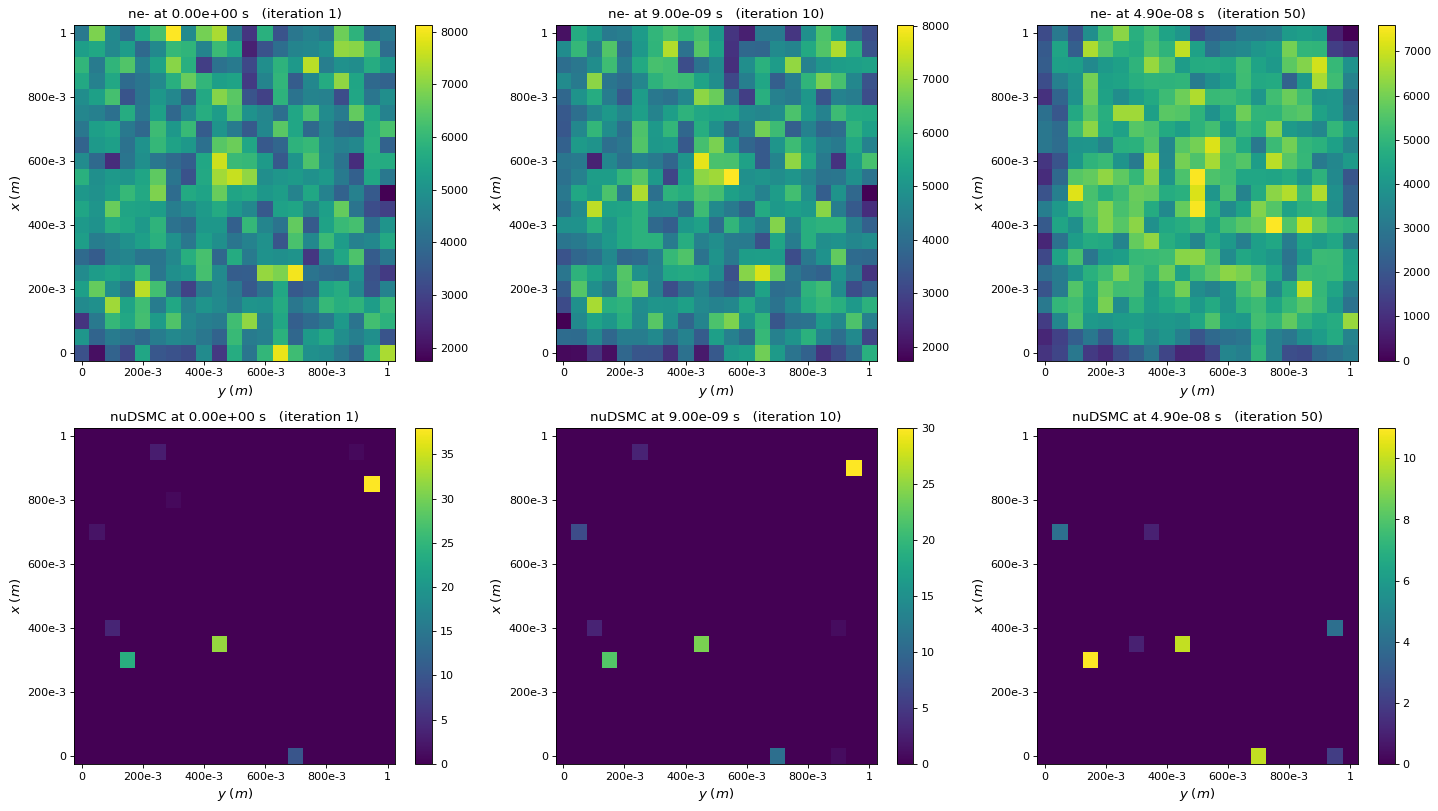

In [2]:
fig = plt.figure(figsize=(22, 12), dpi=80, facecolor="w", edgecolor="k")

plt.subplot(2, 3, 1); ts.get_field("ne-", iteration=1,  plot=true);
plt.subplot(2, 3, 2); ts.get_field("ne-", iteration=10, plot=true);
plt.subplot(2, 3, 3); ts.get_field("ne-", iteration=50, plot=true);

plt.subplot(2, 3, 4); ts.get_field("nuDSMC", iteration=1,  plot=true);
plt.subplot(2, 3, 5); ts.get_field("nuDSMC", iteration=10, plot=true);
plt.subplot(2, 3, 6); ts.get_field("nuDSMC", iteration=50, plot=true);